# Analysing Glassdoor Reviews: Impact of Job Satisfaction on Employee Retention and Firm Performance in the IT Industry

The goal here is to create **regression models** to help with the titular objective. We want to determine the impact of **job satisfaction** on:
1. **Employee retention**, and
2. **Firm performance**,
3. within the **IT industry** only.

Our data sources are **Glassdoor**, **Compustat** for retrieving measures of firm financial performance, and a **Ticker** dataset to match company names with their tickers, ensuring that financial data can be retrieved for the companies reviewed on Glassdoor. 

To achieve our goal, we'll follow these steps:
1. Scrape Glassdoor reviews
2. Clean Glassdoor data
3. Retrieve tickers of the **top public IT firms**, effectively restricting the scope to only companies within the IT Industry, and only those with publicly available financial data
4. Merge datasets
5. Clean merged data
6. Exploratory data analysis
7. Extract employee retention data from Glassdoor review data
8. Retrieve financial performance data
9. Merge into final dataset and prepare for linear regression
10. Create **regression models** on final dataset
11. Compare and evaluate model performances

## Step 1: Scrape Glassdoor reviews

Glassdoor reviews have been pre-scraped using selenium chromedriver. Here's an example of what we're scraping:

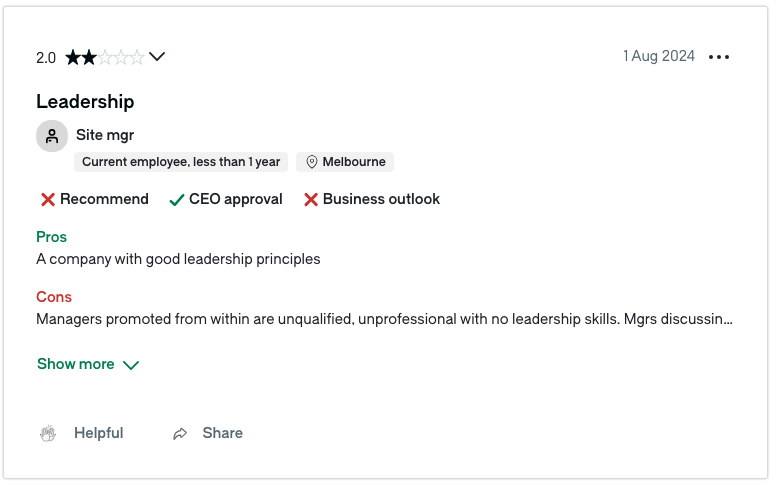

So, we might expect the following columns:
- overall rating
- title
- employee status
- recommend
- CEO approval
- business outlook
- pros
- cons
- date

and of course **company**. On top of that, each review also comes with category ratings:

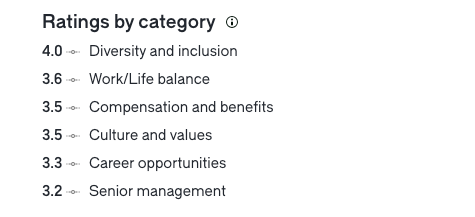

So we can expect those columns too. 

With the scraping complete, let's move to data inspection and cleaning.

## Step 2: Clean Glassdoor Data

First let's get a preview of the data.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/all-reviews.csv', low_memory=False)
print(df.info())

/Users/matth/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901889 entries, 0 to 9901888
Data columns (total 19 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   rating                     float64
 1   title                      object 
 2   status                     object 
 3   pros                       object 
 4   cons                       object 
 5   advice                     object 
 6   Recommend                  object 
 7   CEO Approval               object 
 8   Business Outlook           object 
 9   Career Opportunities       object 
 10  Compensation and Benefits  object 
 11  Senior Management          object 
 12  Work/Life Balance          object 
 13  Culture & Values           float64
 14  Diversity & Inclusion      float64
 15  firm_link                  object 
 16  date                       object 
 17  job                        object 
 18  index                      float64
dtypes: float64(4), object(15)
memory usage: 1.

Nice. So we have **9,901,889** rows, 19 columns, and all the expected columns from the images above. Let's have a look at the data itself.

In [2]:
df.head(2)

,rating,title,status,pros,cons,advice,Recommend,CEO Approval,Business Outlook,Career Opportunities,Compensation and Benefits,Senior Management,Work/Life Balance,Culture & Values,Diversity & Inclusion,firm_link,date,job,index
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,NaN,v,o,v,3,3,3,3,3.0,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design,NaN
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",NaN,v,o,o,4,4,4,4,4.0,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee,NaN


Looks good. Things to note here:
- there's clearly some null data
- firm link doesn't actually contain the company, just some sort of URL
- there's a mismatch in typing between some of the numerical columns - integer vs float
- the company name will need to be extracted from the firm link
- the columns (Recommend, CEO Approval, Business Outlook) are represented by letters

This letter ratings are as follows:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

To actually work with these, we'll need to decide how to convert these accurately to a numerical scale later on.

For now, let's start cleaning the data.

In [3]:
print(df.isnull().sum())

rating                           171
title                          39424
status                           171
pros                             188
cons                             234
advice                       9901876
Recommend                        171
CEO Approval                     171
Business Outlook                 171
Career Opportunities         1848262
Compensation and Benefits    1878091
Senior Management            1975466
Work/Life Balance            1894490
Culture & Values             2246773
Diversity & Inclusion        6544282
firm_link                          0
date                             171
job                              171
index                        9740269
dtype: int64


Clearly there is a lot of missing data, so we have to decide what to do with it.

There are **9.9M+** rows, and the **'advice'** column is missing almost all of these, so we can drop that. 

Now, it looks like **Diversity & Inclusion** is missing more than half the rows, so it was probably introduced recently. Seeing as we have all the other measures, it won't impact our models too much if we drop it, and besides, it isn't a great measure of job satisfaction.

The **index** column seems to be unnecessary, so that can be dropped too.

In [4]:
df.drop(columns=['advice','index','Diversity & Inclusion'], inplace=True)

Sweet. It'd be nice to rename the columns to shorter, more concise names. Let's do that.

In [5]:
rename_cols = {'status':'retention','Ticker':'ticker','Recommend':'recommend','CEO Approval':'ceo_approv','Business Outlook':'bus_outlook','Career Opportunities':'career_opps','Compensation and Benefits':'comp_benefits','Senior Management':'senior_mgmt','Work/Life Balance':'wl_balance','Culture & Values':'cult_values'}
df = df.rename(columns=rename_cols)

Great. From here, we need to decide how to deal with the remaining missing values. We shouldn't need to remove any more columns - the simplest solution will probably be to just remove all rows with missing values. If we do so we'll lose **2,246,773** rows due to the Nulls in Culture & Values, but given the huge dataset size that's not a bad tradeoff. Let's try it.

In [6]:
cleaned_df = df.dropna()
print(cleaned_df.isnull().sum())

rating           0
title            0
retention        0
pros             0
cons             0
recommend        0
ceo_approv       0
bus_outlook      0
career_opps      0
comp_benefits    0
senior_mgmt      0
wl_balance       0
cult_values      0
firm_link        0
date             0
job              0
dtype: int64


No more Nulls. Let's take a look at our data now.

In [7]:
print(cleaned_df.shape)
cleaned_df.head(2)

(7488389, 16)


,rating,title,retention,pros,cons,recommend,ceo_approv,bus_outlook,career_opps,comp_benefits,senior_mgmt,wl_balance,cult_values,firm_link,date,job
0,5.0,Good,"Current Employee, more than 10 years",Knowledge gain of complete project,Financial growth and personal growth,v,o,v,3,3,3,3,3.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Nov 19, 2022",Manager Design
1,4.0,Good,"Former Employee, less than 1 year","Good work,good work , flexible, support","Good,work, flexible,good support, good team work",v,o,o,4,4,4,4,4.0,Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm,"Jan 29, 2022",Anonymous Employee


Great, we now have **7.4M+** rows of complete data. 

Next, we'll focus on merging this data with the top public IT firm Tickers - the reason being that this will cut out a lot more of the data, making future calculations simpler and faster. First thing we need to do is extract the firm name from the **firm_link** URL. Let's see:

### Converting firm_link to Company Name

First off, some examples to see what we're working with.

In [8]:
import re
import urllib.parse

print(cleaned_df.firm_link[1])
print(cleaned_df.firm_link[469])
print(cleaned_df.firm_link[1901])
print(cleaned_df.firm_link[5901])
print(cleaned_df.firm_link[99802])

Reviews/Baja-Steel-and-Fence-Reviews-E5462645.htm
https://www.glassdoor.com/Reviews/Canada-Life-Reviews-E23636.htm
Reviews/SS&C-Advent-Reviews-E646079.htm
https://www.glassdoor.com/Reviews/Boston-Red-Sox-Reviews-E5205.htm
Reviews/Chipotle-Reviews-E1370610.htm


With textual URL data like this, there can always be interesting UTF-8 character representations using the % sign. For example, accents can't be typed into URLs.

In [9]:
for index, firm_link in cleaned_df.firm_link.items():
    if "%" in firm_link:
        print(firm_link)
        print(index)
        break

https://www.glassdoor.com/Reviews/Universit%C3%A9-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm
135445


A good example here with an accent. The urllib.parse library provides an easy way to convert these representations into the correct Unicode characters:

In [10]:
ctr = 0
for index, firm_link in cleaned_df['firm_link'].items():
    if "%" in firm_link:
        cleaned_df.at[index, 'firm_link'] = urllib.parse.unquote(firm_link)

In [11]:
print(cleaned_df.firm_link.loc[135445])

https://www.glassdoor.com/Reviews/Université-Toulouse-III-Paul-Sabatier-Reviews-E753896.htm


Looks like we've fixed it.

Next up, we need to extract the firm names. It's always after 'Reviews/' and before '-Reviews'. We'll use regex. To make things simpler, we'll also remove hyphens because the URL links add a hyphen between each word of the company. This is a significant change, but it also makes it easier to merge with the Ticker data.

In [12]:
cleaned_df = cleaned_df.rename(columns={'firm_link':'firm'})
cleaned_df['firm'] = cleaned_df['firm'].str.extract(r'(?<=Reviews\/)(.*)(?=-Reviews)')
cleaned_df['firm'] = cleaned_df['firm'].str.replace('-',' ', regex=False)
print(cleaned_df['firm'].head(2))
print(cleaned_df['firm'].tail(2))

0    Baja Steel and Fence
1    Baja Steel and Fence
Name: firm, dtype: object
9901887    Victoria Inn Hotel & Convention Centre
9901888    Victoria Inn Hotel & Convention Centre
Name: firm, dtype: object


Done. Ready to merge with the Ticker data by firm name.

## Step 3: Retrieve top public IT firm Tickers

We've retrieved a ticker dataset of the top public IT companies retrieved from https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/.

By merging this dataset with our own, we can very easily fetch financial data for each company being reviewed.

A good way to match Ticker to company name will be with some sort of fuzzy match / cosine similarity score.

In [13]:
tech_firm_tickers_df = pd.read_csv('data/tech-firms-by-market-cap.csv')
print(tech_firm_tickers_df.head(5))
print(tech_firm_tickers_df.shape, "\n")
print(tech_firm_tickers_df.isnull().sum())
tech_firm_tickers_df = tech_firm_tickers_df.dropna()
print("\n", tech_firm_tickers_df.shape)

   Rank               Name Symbol     marketcap  price (USD)        country
0     1          Microsoft   MSFT  3.073560e+12       413.54  United States
1     2              Apple   AAPL  2.786360e+12       181.71  United States
2     3             NVIDIA   NVDA  2.303500e+12       921.40  United States
3     4  Alphabet (Google)   GOOG  2.086900e+12       169.83  United States
4     5             Amazon   AMZN  1.963730e+12       188.70  United States
(952, 6) 

Rank           0
Name           0
Symbol         1
marketcap      0
price (USD)    0
country        0
dtype: int64

 (951, 6)


Interesting. So we have **951** companies in the Ticker dataset.

In [14]:
glassdoor_companies = pd.DataFrame(cleaned_df['firm'].unique(), columns=['Firm'])
print(glassdoor_companies.shape)

(31750, 1)


Meanwhile, we have **31,750** in the Glassdoor dataset. Let's hope we don't lose too much data in the merge.

Let's start with a simple equality match:

In [16]:
ctr = 0
for company1 in tech_firm_tickers_df['Name']:
    for company2 in glassdoor_companies['Firm']:
        if company1.lower() == company2.lower():
            ctr += 1
            break
print("%s matches on equality." % ctr)

211 matches on equality.


211 is not a lot - let's use a more advanced option. For more details, check out https://github.com/DeNederlandscheBank/name_matching.

In [17]:
from name_matching.name_matcher import NameMatcher

matcher = NameMatcher(top_n=500,
    number_of_rows=31750,
    lowercase=True,
    punctuations=True,
    remove_ascii=True,
    legal_suffixes=False,
    common_words=True,
    verbose=True)

In [18]:
matcher.load_and_process_master_data('Firm', glassdoor_companies)
matches = matcher.match_names(to_be_matched=tech_firm_tickers_df, column_matching='Name')

preprocessing...

preprocessing complete 
 searching for matches...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


possible matches found   
 fuzzy matching...



100%|█████████████████████████████████████████| 951/951 [05:21<00:00,  2.96it/s]

done


In [19]:
print(matches.head(2))
print((matches['score'] == 0.0).sum().sum())
print((matches['score'] == 100.0).sum().sum())
print((matches['score'] >= 75.0).sum().sum())
print(matches.isnull().sum())

  original_name match_name  score  match_index
0     microsoft  microsoft  100.0         4708
1         apple      apple  100.0         9166
71
237
350
original_name    0
match_name       0
score            0
match_index      0
dtype: int64


Interesting. This time we got **350** company names with a matching score of greater than 75%, and **237** with a match of 100%. **This isn't great** - some of the companies with 75% may not be the same company at all, and there are many edge cases. As such, I've exported the matching data to clean the matches manually.

In [20]:
matches.to_csv('data/matches.csv', index=False)

I used this next section of code to help with my manual cleaning. I checked the number of reviews for companies that didn't sound familiar - if they had few reviews, I dropped them.

In [21]:
companies = cleaned_df['firm'].copy()
comp_counts = companies.value_counts()
comp_pcts = companies.value_counts(normalize=True)

checks = ['sohu', 'cognizant']


for company, count in comp_counts.items():
    for check in checks:
        if check in company.lower() and count > 50:
            print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company]*100, company))

64066 reviews, 0.86%: Cognizant Technology Solutions


I then saved the updated matches to a new file - **matches-updated.csv**. The match index hadn't changed, so I also added back the Ticker column from the top tickers dataset. If there wasn't a match, I left the column empty which would show up as Null. Let's have a look:

In [22]:
matches_updated = pd.read_csv('data/matches-updated.csv', low_memory=False)
print(matches_updated.head(2))
print(matches_updated.shape, "\n")
print(matches_updated.isnull().sum())
matches_updated = matches_updated.dropna()
print("\n", matches_updated.shape)

  match_name Symbol
0  microsoft   MSFT
1      apple   AAPL
(912, 2) 

match_name    651
Symbol          1
dtype: int64

 (261, 2)


Our number of matches: **261**. This isn't amazing but we'll see how many reviews we're left with. Given that the top public companies will have a significant majority of the reviews, this shouldn't cut out too much from the data - the main cut will come from reviews of companies outside the IT industry.

Next up: the merge.

## Step 4: Merge Datasets

Before merging, let's briefly prepare both datasets. We're dropping the 'index' column - this isn't needed any longer.

In [23]:
tickers_df = matches_updated.rename(columns={"match_name": "firm", "Symbol": "ticker"})
tickers_df = tickers_df.reset_index(drop=True)
print(tickers_df.head(2))
cleaned_df['firm'] = cleaned_df['firm'].apply(lambda x: x.lower())
print(cleaned_df['firm'].head(2))

        firm ticker
0  microsoft   MSFT
1      apple   AAPL
0    baja steel and fence
1    baja steel and fence
Name: firm, dtype: object


**Merge!**

In [24]:
merged_df = cleaned_df.merge(tickers_df, how='right')
print(merged_df.isnull().sum())
print(merged_df.shape)
merged_df = merged_df.dropna()

rating           5
title            5
retention        5
pros             5
cons             5
recommend        5
ceo_approv       5
bus_outlook      5
career_opps      5
comp_benefits    5
senior_mgmt      5
wl_balance       5
cult_values      5
firm             0
date             5
job              5
ticker           0
dtype: int64
(977831, 17)


Amazing, now we have a dataset of **977,831** Glassdoor reviews from 216 public IT companies complete with tickers. This is still a very solid amount of data to work with and we should be able to draw some meaningful analysis.

## Step 5: Clean and Transform Merged Data

Before we start analysing, let's clean and transform the merged data.

First, let's set all the numerical columns to integers. Let's have a look at the **Senior Management** column.

In [25]:
merged_df['senior_mgmt'].value_counts().sort_values(ascending=False)

senior_mgmt
4      223324
3      205124
5      185683
1      114636
2      110509
4.0     35800
5.0     35382
3.0     29740
1.0     20904
2.0     16724
Name: count, dtype: int64

We have both ints and floats, which are clearly these are supposed to be the same type. Let's see which of the other numerical columns need to be fixed:

In [26]:
merged_df.dtypes

rating           float64
title             object
retention         object
pros              object
cons              object
recommend         object
ceo_approv        object
bus_outlook       object
career_opps       object
comp_benefits     object
senior_mgmt       object
wl_balance        object
cult_values      float64
firm              object
date              object
job               object
ticker            object
dtype: object

Remember that recommend, ceo_approv and bus_outlook are letters, which we'll handle momentarily.

Let's convert the other numericals to **floats**:

In [27]:
for col in ['career_opps','comp_benefits','senior_mgmt','wl_balance']:
    merged_df[col] = merged_df[col].astype(float)
merged_df['senior_mgmt'].value_counts().sort_values(ascending=False)

senior_mgmt
4.0    259124
3.0    234864
5.0    221065
1.0    135540
2.0    127233
Name: count, dtype: int64

Much better. Next we need to decide how to deal with the letter ratings. As a reminder:
- **v = Positive**
- **r = Mild**
- **x = Negative**
- **o = No opinion**

In keeping with the scale of the other columns, let's encode these as follows:
- v = 5
- r = 2.5
- x = 0
- o = 2.5

Let's quickly check the uniques of each 'letter' column to make sure we're not missing anything.

In [28]:
print(merged_df['recommend'].value_counts())
print(merged_df['ceo_approv'].value_counts())
print(merged_df['bus_outlook'].value_counts())

recommend
v    630201
x    217689
o    129936
Name: count, dtype: int64
ceo_approv
v    495938
o    210187
r    173547
x     98154
Name: count, dtype: int64
bus_outlook
v    502322
r    178402
o    177870
x    119232
Name: count, dtype: int64


Great, now let's transform them.

In [29]:
for col in ['recommend', 'ceo_approv', 'bus_outlook']:
    for letter, value in {'v':5.0, 'r':2.5, 'x':0, 'o':2.5}.items():
        merged_df.loc[merged_df[col] == letter, col] = value
    merged_df[col] = merged_df[col].astype(float)

    print(merged_df[col].value_counts())

recommend
5.0    630201
0.0    217689
2.5    129936
Name: count, dtype: int64
ceo_approv
5.0    495938
2.5    383734
0.0     98154
Name: count, dtype: int64
bus_outlook
5.0    502322
2.5    356272
0.0    119232
Name: count, dtype: int64


**Sweet.** We can see from the value counts that everything has worked smoothly.

Now we'll want to transform the **date** column from String to DateTime, and extract the **year** and **quarter**. We'll be using the quarter to match the review dates with the financial data during the **linear regression**.

In [30]:
from datetime import datetime

merged_df['date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x).strip(' '), '%b %d, %Y'))
merged_df['year'] = merged_df['date'].dt.year
merged_df['quarter'] = pd.PeriodIndex(merged_df.date, freq='Q')
merged_df.head(2)

,rating,title,retention,pros,cons,recommend,ceo_approv,bus_outlook,career_opps,comp_benefits,senior_mgmt,wl_balance,cult_values,firm,date,job,ticker,year,quarter
0,5.0,It was a good culture,Former Employee,- work from home -good culture -great benefits,-some managers shouldn't be managers,5.0,5.0,2.5,5.0,5.0,5.0,5.0,5.0,microsoft,2023-03-24,Customer Success Manager (CSM),MSFT,2023,2023Q1
1,5.0,Always-changing career and technology opportun...,"Current Employee, more than 10 years",Easy to make an impact on many people around t...,Extreme bureaucracy: random never-ending compl...,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,microsoft,2023-03-19,Principal Program Manager Lead,MSFT,2023,2023Q1


Awesome. Let's have a look at our column types now:

In [31]:
merged_df.dtypes

rating                  float64
title                    object
retention                object
pros                     object
cons                     object
recommend               float64
ceo_approv              float64
bus_outlook             float64
career_opps             float64
comp_benefits           float64
senior_mgmt             float64
wl_balance              float64
cult_values             float64
firm                     object
date             datetime64[ns]
job                      object
ticker                   object
year                      int32
quarter           period[Q-DEC]
dtype: object

Almost done. Last thing to do is to reorder the reviews by **date** and reupdate the index.

In [32]:
merged_df = merged_df.sort_values(by='date').reset_index(drop=True)
merged_df.head(2)

,rating,title,retention,pros,cons,recommend,ceo_approv,bus_outlook,career_opps,comp_benefits,senior_mgmt,wl_balance,cult_values,firm,date,job,ticker,year,quarter
0,4.0,Great place to work,"Current Employee, more than 1 year",Very empowered environment. Pays well.,Make sure you are in the right team.,5.0,5.0,2.5,4.0,4.0,2.0,3.0,3.0,juniper networks,2012-05-22,Senior Software Engineer,JNPR,2012,2012Q2
1,3.0,Worst organic growth within company,"Current Employee, more than 8 years",1. Green Card Processing - The only reason why...,1. Appraisal system is very bad\r\n2. Don't co...,0.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,cognizant technology solutions,2012-05-23,Project Manager,CTSH,2012,2012Q2


## Step 6: Exploratory Data Analysis

Now that we've cleaned and transformed the data, let's have a look at some statistics before merging with the financial data.

First, how many companies do we have?

In [33]:
print(merged_df['firm'].unique().shape)

(256,)


Next let's get an idea of the companies with the most reviews, i.e. more than **30,000**.

In [34]:
comp_counts = merged_df['firm'].value_counts()
over_30k = comp_counts[comp_counts > 30000]
comp_pcts = merged_df['firm'].value_counts(normalize=True)*100

for company, count in over_30k.items():
    print("{} reviews, {:.2f}%: {}".format(count, comp_pcts[company], company))

121747 reviews, 12.45%: amazon
64066 reviews, 6.55%: cognizant technology solutions
56224 reviews, 5.75%: accenture
51109 reviews, 5.23%: hp inc
43579 reviews, 4.46%: infosys
42191 reviews, 4.31%: ibm
36960 reviews, 3.78%: wipro
32830 reviews, 3.36%: oracle


Wow, Amazon makes up 10% of all our reviews. 

### That's pretty significant and worth considering - Amazon isn't necessarily a purely IT company, which may skew our results.

Let's graph that. We'll make the x axis more readable while we're at it.

In [35]:
print(over_30k.index)
over_30k = over_30k.set_axis(['Amazon','Cognizant','Accenture','HP','InfoSys','IBM','WiPro','Oracle'])
print(over_30k.index)

Index(['amazon', 'cognizant technology solutions', 'accenture', 'hp inc',
       'infosys', 'ibm', 'wipro', 'oracle'],
      dtype='object', name='firm')
Index(['Amazon', 'Cognizant', 'Accenture', 'HP', 'InfoSys', 'IBM', 'WiPro',
       'Oracle'],
      dtype='object')


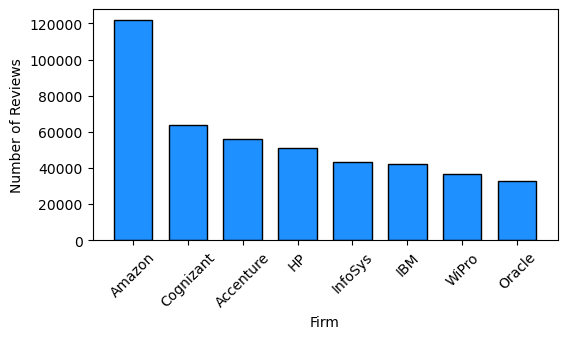

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.bar(over_30k.index.to_list(), height=over_30k, width=0.7, color='dodgerblue', edgecolor='black')
plt.xlabel('Firm')
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews')
plt.show()

Let's create a review year histogram:

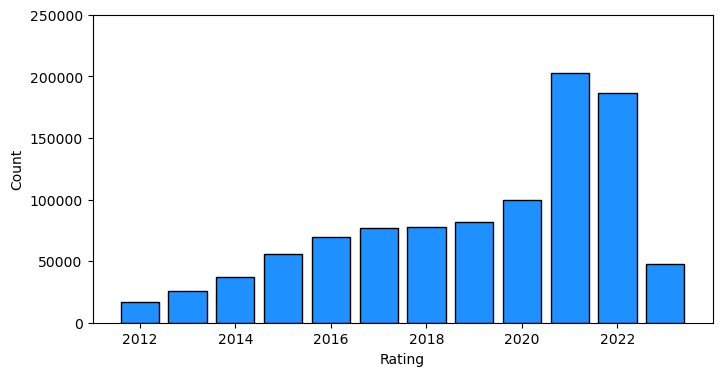

In [37]:
year_counts = merged_df['year'].value_counts(sort=False).sort_index().to_list()

x_labels = list(merged_df['year'].unique())

plt.figure(figsize=(8,4))
plt.bar(x_labels, height=year_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.ylim(top=250000)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

That's striking. A huge uptick in reviews from **2021-2022**. COVID-19?

Overall rating stats:

In [38]:
merged_df.describe()['rating']

count    977826.000000
mean          3.761296
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
std           1.162151
Name: rating, dtype: float64

Average rating is **3.76**/5.

Next, plotting the review star rating value counts:

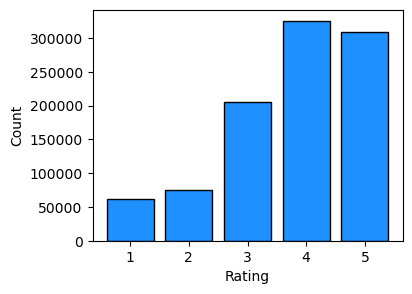

In [39]:
rating_counts = merged_df['rating'].value_counts(sort=False).sort_index().to_list()

plt.figure(figsize=(4,3))
plt.bar([1,2,3,4,5], height=rating_counts, width=0.8, color='dodgerblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Summary statistics for the Positive/Negative columns:

In [40]:
pos_neg_cols = ['recommend', 'ceo_approv', 'bus_outlook']
pos_neg_stats = merged_df.describe()[pos_neg_cols]
pos_neg_stats = pos_neg_stats.drop(['count','min','25%','50%','75%','max'])
pos_neg_stats

,recommend,ceo_approv,bus_outlook
mean,3.554666,3.517011,3.479443
std,2.075372,1.662217,1.735943


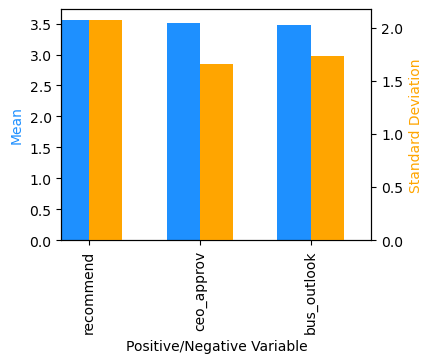

In [41]:
fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

pos_neg_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
pos_neg_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

ax.set_xlabel('Positive/Negative Variable')
ax.set_xticklabels(labels = pos_neg_cols)
ax.set_ylabel('Mean')
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

The way to understand the above graph is that reviews generally recommended IT firms more positively than their business outlook.

In [42]:
job_sat_cols = ['career_opps','comp_benefits','senior_mgmt','wl_balance', 'cult_values']
job_sat_stats = merged_df.describe()[job_sat_cols]
job_sat_stats = job_sat_stats.drop(['count','min','25%','50%','75%','max'])
job_sat_stats

,career_opps,comp_benefits,senior_mgmt,wl_balance,cult_values
mean,3.604290,3.573952,3.309811,3.620070,3.756234
std,1.225656,1.173437,1.325860,1.265199,1.273904


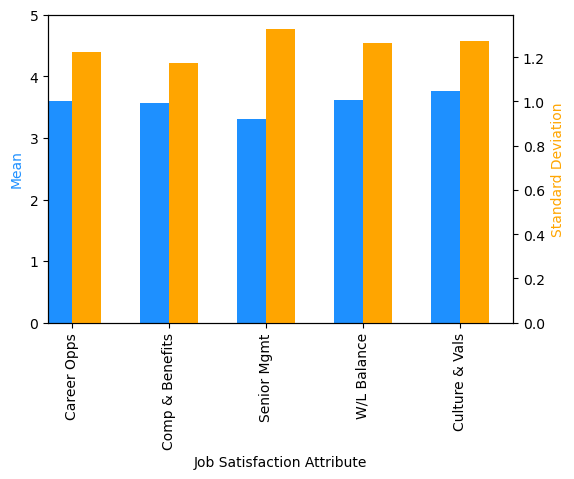

In [43]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

job_sat_stats.loc['mean'].plot(kind='bar', color='dodgerblue', ax=ax, width=0.3, position=1)
job_sat_stats.loc['std'].plot(kind='bar', color='orange', ax=ax2, width=0.3, position=0)

job_sat_labels = ['Career Opps','Comp & Benefits','Senior Mgmt','W/L Balance','Culture & Vals']

ax.set_xlabel('Job Satisfaction Attribute')
ax.set_xticklabels(labels = job_sat_labels)
ax.set_ylabel('Mean')
ax.set_ylim(top=5)
ax.yaxis.label.set_color('dodgerblue')
ax2.yaxis.label.set_color('orange')
ax2.set_ylabel('Standard Deviation')

plt.show()

Very interesting. People tend to rate **Culture & Values** the **highest**, and **Senior Management** the **lowest**. Notably, Senior Management also **varies the most** - people tend to either love or hate upper management in the IT industry.

With the exploratory data analysis complete, let's extract our final feature - employee retention.

## Step 7: Extract employee retention data from Glassdoor review data

Every review also has a **retention** value, which indicates whether the employee is a current or former employee. We can use this to determine and set retention/turnover:
- **Retention = True**
- **Turnover = False**

In [44]:
print(merged_df['retention'].unique())

['Current Employee, more than 1 year'
 'Current Employee, more than 8 years'
 'Current Employee, more than 3 years'
 'Former Employee, more than 3 years'
 'Current Employee, more than 10 years'
 'Current Employee, less than 1 year' 'Former Employee, more than 1 year'
 'Current Employee' 'Former Employee'
 'Former Employee, more than 10 years'
 'Current Employee, more than 5 years' 'Former Employee, less than 1 year'
 'Former Employee, more than 5 years' 'Former Employee, more than 8 years'
 'Current Freelancer' 'Current Intern, less than 1 year'
 'Former Intern, less than 1 year' 'Former Contractor, less than 1 year'
 'Former Freelancer, more than 3 years' 'Current Contractor'
 'Current Freelancer, more than 8 years']


There are many uniques, but they all share a commonality, they either start with **Current** or **Former**. That makes our job easy:

In [45]:
merged_df['retention'] = merged_df['retention'].str.split(' ').str[0]
print(merged_df['retention'].unique())

for retention, value in {'Current':True, 'Former':False}.items():
    merged_df.loc[merged_df['retention'] == retention, 'retention'] = value

merged_df['retention'] = merged_df['retention'].astype(bool)

print(merged_df['retention'].value_counts())

['Current' 'Former']
retention
True     649146
False    328680
Name: count, dtype: int64


In [46]:
merged_df.head(2)

,rating,title,retention,pros,cons,recommend,ceo_approv,bus_outlook,career_opps,comp_benefits,senior_mgmt,wl_balance,cult_values,firm,date,job,ticker,year,quarter
0,4.0,Great place to work,True,Very empowered environment. Pays well.,Make sure you are in the right team.,5.0,5.0,2.5,4.0,4.0,2.0,3.0,3.0,juniper networks,2012-05-22,Senior Software Engineer,JNPR,2012,2012Q2
1,3.0,Worst organic growth within company,True,1. Green Card Processing - The only reason why...,1. Appraisal system is very bad\r\n2. Don't co...,0.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,cognizant technology solutions,2012-05-23,Project Manager,CTSH,2012,2012Q2


Done. Let's see the retention data:

In [47]:
retention_stats = merged_df['retention'].value_counts()
print(retention_stats)
retention_pcts = merged_df['retention'].value_counts(normalize=True)*100
print(retention_pcts)

retention
True     649146
False    328680
Name: count, dtype: int64
retention
True     66.386658
False    33.613342
Name: proportion, dtype: float64


Graphed:

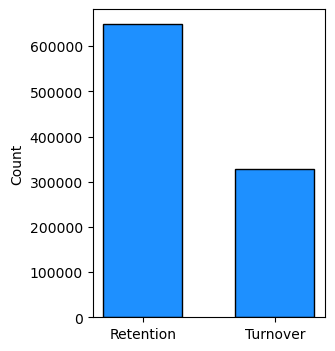

In [48]:
plt.figure(figsize=(3,4))
plt.bar(['Retention', 'Turnover'], height=retention_stats, width=0.6, color='dodgerblue', edgecolor='black')
plt.ylabel('Count')
plt.show()

**Done**. Ready for regression analysis. Next up - retrieving financial data.

## Step 8: Retrieve financial performance data

Great, now the next step is to retrieve financials for each company. We'll need to choose what exactly we want to use as our measure of financial performance. This is a highly debated topic in finance, so we just want to choose something simple. Some ideas:
- **EPS**
- **Market Capitalisation (MCAP)**
- **Total Revenue**
- **Return on Assets (ROA)**

Let's choose **MCAP** and **ROA**. We'll go into more detail later, but market cap is a great general indicator of firm size but is strongly influenced by market fluctuations, while return on assets is much less exposed to market fluctuations while still accounting for both **tangible** and **intangible assets**. This makes sense for our analysis, given that the output of productive employees is not always tangible.

Let's try first with **Yahoo Finance**.

### Attempt 1: Yahoo Finance (not necessarily relevant, feel free to skip to Attempt 2)

In [49]:
financials = ['industry']

In [50]:
import yfinance as yf
import requests

stock = yf.Ticker('AAPL')
financials = ['trailingEps','marketCap','totalRevenue','returnOnAssets']

print(f"{stock.info['shortName']} ({stock.info['symbol']})")
for financial in financials:
    print(f"{financial}: {stock.info[financial]}")

Apple Inc. (AAPL)
trailingEps: 6.57
marketCap: 3542555295744
totalRevenue: 385603010560
returnOnAssets: 0.22612


These are current values... let's see if we can get AAPL's EPS in Q1 2018 as an example:

In [51]:
print(stock.financials.loc['Diluted EPS'])
print(stock.financials.loc['Basic EPS'])
print(stock.quarterly_income_stmt.loc['Diluted EPS'])
print(stock.quarterly_income_stmt.loc['Basic EPS'])

2023-09-30    6.13
2022-09-30    6.11
2021-09-30    5.61
2020-09-30    3.28
Name: Diluted EPS, dtype: object
2023-09-30    6.16
2022-09-30    6.15
2021-09-30    5.67
2020-09-30    3.31
Name: Basic EPS, dtype: object
2024-06-30     1.4
2024-03-31    1.53
2023-12-31    2.18
2023-09-30    1.46
2023-06-30    1.26
2023-03-31     NaN
Name: Diluted EPS, dtype: object
2024-06-30     1.4
2024-03-31    1.53
2023-12-31    2.19
2023-09-30    1.47
2023-06-30    1.27
2023-03-31     NaN
Name: Basic EPS, dtype: object


No luck... the data only goes back either 4 years or 5 quarters.

In [52]:
stock.get_earnings_dates(limit=20)

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-07-30 06:00:00-04:00,NaN,NaN,NaN
2025-04-30 06:00:00-04:00,NaN,NaN,NaN
2025-01-30 16:00:00-05:00,NaN,NaN,NaN
2024-10-31 06:00:00-04:00,1.60,NaN,NaN
2024-08-01 16:00:00-04:00,1.35,1.40,0.0399
2024-05-02 16:00:00-04:00,1.50,1.53,0.0197
2024-02-01 16:00:00-05:00,2.10,2.18,0.0390
2023-11-02 16:00:00-04:00,1.39,1.46,0.0492
2023-08-03 16:00:00-04:00,1.19,1.26,0.0549


EPS is the only measure we can get a hold of. Unfortunately this isn't enough for our analysis. Let's try a different option.

### Attempt 2: CRSP/Compustat Merged financial database

This database requires institutional access. Register for the service at https://wrds-www.wharton.upenn.edu/register/.

The CRSP/Compustat Merged database is very large and very in-depth compared to most. It allows for almost unlimited customisation in queries, so we need to be specific in the data we want.

As a reminder, we need our financial data in **quarterly form**, which we will match up with the reviews that are posted in that quarter. The first and last dates/quarters of our reviews are as follows:

In [53]:
print(merged_df['date'].head(1).iloc[0])
print(merged_df['date'].tail(1).iloc[0])
print(merged_df['quarter'].head(1).iloc[0])
print(merged_df['quarter'].tail(1).iloc[0])

2012-05-22 00:00:00
2023-07-10 00:00:00
2012Q2
2023Q3


So, our query is as follows. We want the:
- **market cap**, and
- **return on assets**,
- for every unique ticker in our database,
- from **Q2 2012** to **Q3 2023**.

CRSP allows for a **.txt** file of each of the ticker names separated by a line to be used as input. Let's generate that:

In [54]:
with open('unique_tickers.txt', 'w') as file:
    for ticker in merged_df['ticker'].unique():
        file.write(f"{ticker}\n")

Great. Now let's see if we run the query above with the **unique_tickers.txt** file to the query builder at https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/fundamentals-quarterly. 

Note that we are searching in the **Fundamentals Quarterly** section of the database.

So, turns out that neither Market Cap nor Return on Assets are available as variables within the database. However, the variables in their formulas are indeed available. Namely:

- Market Cap = **Shares Outstanding x Share Price**
- Return on Assets = **Net Income / Total Assets**

So, let's instead retrieve those four variables.

After running the query, the data has been cleaned and prepared in **crsp-compustat-data.csv**. Let's check it out.

In [55]:
financials_df = pd.read_csv('data/crsp-compustat-data.csv', low_memory=False)
financials_df.head(2)

,tic,datafqtr,atq,cshoq,niq,prccq
0,AMD,2012Q2,5041.0,707.0,37.0,5.73
1,AMD,2012Q3,4612.0,712.0,-157.0,3.37


Let's start with the column names:
- tic = **Ticker**
- datafqtr = **Financial Quarter**
- atq = **Assets Total (Quarterly)** (USD millions)
- cshoq = **Common Shares Outstanding (Quarterly)** (USD millions)
- niq = **Net Income (Quarterly)** (USD millions)
- prccq = **Price Close (Quarterly)** (USD)

Let's see how many firm tickers matched up correctly.

In [56]:
financials_df = financials_df.rename(columns={'tic':'ticker','datafqtr':'quarter'})
print(financials_df.shape)
print(len(financials_df['ticker'].unique()))

(9372, 6)
232


So out of the **252** initial tickers, we've found **232** companies with matching financial data. Nice.

Let's convert these variables into **MCAP** and **ROA** and drop them afterwards.

In [57]:
financials_df['mcapq'] = financials_df['cshoq'] * financials_df['prccq']
financials_df['roaq'] = financials_df['niq'] / financials_df['atq']
financials_df.drop(columns=['cshoq','prccq','niq','atq'], inplace=True)
financials_df.head(2)

,ticker,quarter,mcapq,roaq
0,AMD,2012Q2,4051.11,0.007340
1,AMD,2012Q3,2399.44,-0.034042


Perfect. Onto the merge step.

## Step 9: Merge into final dataset and prepare for linear regression



Let's prepare the merge. We're going to merge by ticker and quarter. Ideally we want to remove all non-matching rows early so the merge is less complex. We know the tickers will match since we searched the database with them, let's make sure we don't have any quarters outside the range **Q2 2012** to **Q3 2023**.

In [58]:
print(financials_df['quarter'].unique())

['2012Q2' '2012Q3' '2012Q4' '2013Q1' '2013Q2' '2013Q3' '2013Q4' '2014Q1'
 '2014Q2' '2014Q3' '2014Q4' '2015Q1' '2015Q2' '2015Q3' '2015Q4' '2016Q1'
 '2016Q2' '2016Q3' '2016Q4' '2017Q1' '2017Q2' '2017Q3' '2017Q4' '2018Q1'
 '2018Q2' '2018Q3' '2018Q4' '2019Q1' '2019Q2' '2019Q3' '2019Q4' '2020Q1'
 '2020Q2' '2020Q3' '2020Q4' '2021Q1' '2021Q2' '2021Q3' '2021Q4' '2022Q1'
 '2022Q2' '2022Q3' '2022Q4' '2023Q1' '2023Q2' '2023Q3' '2023Q4' '2024Q1'
 '2024Q2' '2012Q1' '2024Q3']


So, it looks like **2023Q4, 2024Q1, 2024Q2, 2012Q1** and **2024Q3** are outside our range.

That being said, these may come in handy later on for predicting future quarterly data. Specifically **2012Q1** and **2023Q4** for predicting the previous and next quarterly financial data from the current quarter's reviews. Alright, let's keep those for now and drop all other rows outside the range.

In [59]:
quarters_to_drop = ['2024Q1','2024Q2','2024Q3']
financials_df = financials_df[~financials_df['quarter'].isin(quarters_to_drop)]

print(financials_df.shape)
print(len(financials_df['ticker'].unique()))

(9105, 4)
232


Sweet, we didn't lose any of the 232 tickers. 

Next, let's add in the past and future quarter columns. We need these to be able to calculate the past and future percentage change in market cap and roa, which we'll be predicting.

In [60]:
financials_df['mcapq_next'] = financials_df.groupby('ticker')['mcapq'].shift(-1)
financials_df['roaq_next'] = financials_df.groupby('ticker')['roaq'].shift(-1)
financials_df['mcapq_prev'] = financials_df.groupby('ticker')['mcapq'].shift(1)
financials_df['roaq_prev'] = financials_df.groupby('ticker')['roaq'].shift(1)
financials_df.tail(5)

,ticker,quarter,mcapq,roaq,mcapq_next,roaq_next,mcapq_prev,roaq_prev
9367,MYNA,2022Q4,96.121888,-0.517812,147.76571,-0.361002,106.059780,-0.419811
9368,MYNA,2023Q1,147.765710,-0.361002,158.33090,-0.261591,96.121888,-0.517812
9369,MYNA,2023Q2,158.330900,-0.261591,120.49429,-0.387141,147.765710,-0.361002
9370,MYNA,2023Q3,120.494290,-0.387141,147.62212,-0.516292,158.330900,-0.261591
9371,MYNA,2023Q4,147.622120,-0.516292,NaN,NaN,120.494290,-0.387141


That worked, but we'll probably have a fair few null values where there is no future quarter data. Let's see how many:

In [61]:
print(financials_df.shape)
print(financials_df.isnull().sum())

(9105, 8)
ticker          0
quarter         0
mcapq           0
roaq            0
mcapq_next    232
roaq_next     232
mcapq_prev    232
roaq_prev     232
dtype: int64


As expected, we have 232 null values which corresponds to the 232 different companies (i.e. each time the value changes to the next ticker, we get a null value). Theoretically, most of these null values should be in the additional quarters we kept: 2012Q1 and 2023Q4. 

We can drop these quarters now, seeing as our review data doesn't exist in those quarters, along with all the null rows:

In [62]:
financials_df = financials_df[financials_df['quarter'] != '2012Q1']
financials_df = financials_df[financials_df['quarter'] != '2023Q4']
financials_df = financials_df.dropna()
print(financials_df.shape)

(8642, 8)


Sweet. Next, let's make the most important change of all: we need to convert the financial data to **percentage change**. Specifically, we have the previous, current, and next mcap & roa. We need to convert these to two columns: the **previous-current percentage change** and the **current-next percentage change**.

In [63]:
financials_df['mcapq_prev_change'] = ((financials_df['mcapq'] - financials_df['mcapq_prev']) / financials_df['mcapq_prev'])
financials_df['mcapq_next_change'] = ((financials_df['mcapq_next'] - financials_df['mcapq']) / financials_df['mcapq'])
financials_df['roaq_prev_change'] = ((financials_df['roaq'] - financials_df['roaq_prev']) / financials_df['roaq_prev'])
financials_df['roaq_next_change'] = ((financials_df['roaq_next'] - financials_df['roaq']) / financials_df['roaq'])
financials_df.head(2)

,ticker,quarter,mcapq,roaq,mcapq_next,roaq_next,mcapq_prev,roaq_prev,mcapq_prev_change,mcapq_next_change,roaq_prev_change,roaq_next_change
1,AMD,2012Q3,2399.44,-0.034042,1711.2,-0.118250,4051.11,0.007340,-0.407708,-0.286834,-5.637942,2.473688
2,AMD,2012Q4,1711.20,-0.118250,1820.7,-0.038451,2399.44,-0.034042,-0.286834,0.063990,2.473688,-0.674830


Nice. With that done, we can drop all the other financial data columns.

In [64]:
financials_df.drop(columns=['mcapq','roaq','mcapq_next','roaq_next','mcapq_prev','roaq_prev'], inplace=True)

Now that we have the percentage change data, we should check for big outliers, and possibly normalize the data immediately. Let's have a look. Note that the min/max of the next and prev columns will be the same.

In [65]:
print(financials_df['mcapq_prev_change'].describe().drop(['25%','50%','75%']))
print(financials_df['roaq_prev_change'].describe().drop(['25%','50%','75%']))

count    8642.000000
mean        0.053396
std         0.512323
min        -0.750752
max        40.407334
Name: mcapq_prev_change, dtype: float64
count    8642.000000
mean        0.567089
std        32.990305
min      -914.557888
max      1514.880473
Name: roaq_prev_change, dtype: float64


So clearly the market cap has an abnormally large max with a small standard deviation, while ROA has abnormally large min and max with a pretty high standard deviation. Either way, we'll need some special normalization methods. To make this clearer, let's graph the data with **scatter plots**.

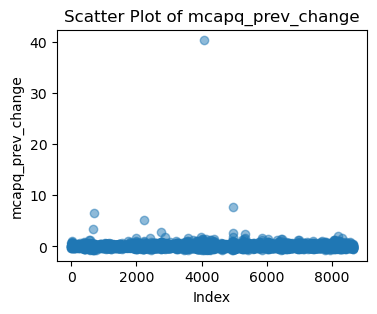

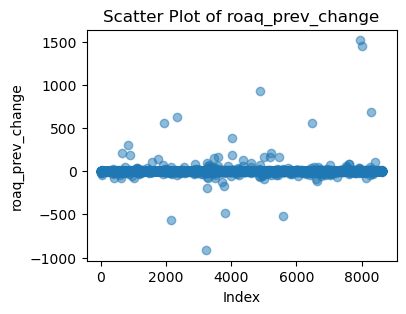

In [66]:
plt.figure(figsize=(4, 3))
plt.scatter(range(len(financials_df['mcapq_prev_change'])), financials_df['mcapq_prev_change'], alpha=0.5)
plt.title('Scatter Plot of mcapq_prev_change')
plt.xlabel('Index')
plt.ylabel('mcapq_prev_change')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(range(len(financials_df['roaq_prev_change'])), financials_df['roaq_prev_change'], alpha=0.5)
plt.title('Scatter Plot of roaq_prev_change')
plt.xlabel('Index')
plt.ylabel('roaq_prev_change')
plt.show()

Given that most of the data in both **mcap** and **roa** is regularly distributed besides some extreme values, we'll normalise by first using **Winsorization** followed by **Min-Max Scaling**. Winsorization clips the extreme values to certain upper and lower bounds (1st and 99th percentile), while Min-Max Scaling will normalize the data to within our desired range (0, 5) to be exactly in line with the input variables for our future machine learning models.

Let's apply that to all four columns.

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,5))

for col in ['mcapq_prev_change','mcapq_next_change','roaq_prev_change','roaq_next_change']:
    lower_bound = np.percentile(financials_df[col], 0.1)
    upper_bound = np.percentile(financials_df[col], 99.9)
    financials_df[col] = np.clip(financials_df[col], lower_bound, upper_bound) # Winsorization
    financials_df[col] = scaler.fit_transform(financials_df[[col]])

That's a big step. Let's have another look at the scatter plots.

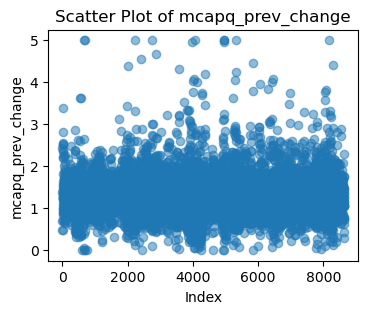

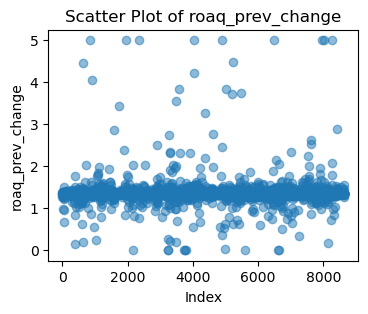

In [68]:
plt.figure(figsize=(4, 3))
plt.scatter(range(len(financials_df['mcapq_prev_change'])), financials_df['mcapq_prev_change'], alpha=0.5)
plt.title('Scatter Plot of mcapq_prev_change')
plt.xlabel('Index')
plt.ylabel('mcapq_prev_change')
plt.show()

plt.figure(figsize=(4, 3))
plt.scatter(range(len(financials_df['roaq_prev_change'])), financials_df['roaq_prev_change'], alpha=0.5)
plt.title('Scatter Plot of roaq_prev_change')
plt.xlabel('Index')
plt.ylabel('roaq_prev_change')
plt.show()

Much, much better. We can see the data has far fewer extreme outliers and sits on a nice scale. **Normalization** complete.

To prepare for the merge, let's convert the **quarter** column in financials_df to a **period[Q-DEC]** to match with merged_df.

In [69]:
financials_df['quarter'] = pd.PeriodIndex(financials_df['quarter'], freq='Q-DEC')
print(merged_df.shape)

(977826, 19)


Time to merge. This will show us if we have any quarterly financial data missing.

In [70]:
final_df = merged_df.merge(financials_df, how='inner')
print(final_df.info())
final_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902643 entries, 0 to 902642
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             902643 non-null  float64       
 1   title              902643 non-null  object        
 2   retention          902643 non-null  bool          
 3   pros               902643 non-null  object        
 4   cons               902643 non-null  object        
 5   recommend          902643 non-null  float64       
 6   ceo_approv         902643 non-null  float64       
 7   bus_outlook        902643 non-null  float64       
 8   career_opps        902643 non-null  float64       
 9   comp_benefits      902643 non-null  float64       
 10  senior_mgmt        902643 non-null  float64       
 11  wl_balance         902643 non-null  float64       
 12  cult_values        902643 non-null  float64       
 13  firm               902643 non-null  object  

,rating,title,retention,pros,cons,recommend,ceo_approv,bus_outlook,career_opps,comp_benefits,...,firm,date,job,ticker,year,quarter,mcapq_prev_change,mcapq_next_change,roaq_prev_change,roaq_next_change
0,5.0,Only change is constant,True,"Dynamic, lots of opportunity, very intelligent...","Always busy, constant change, some folks retir...",5.0,5.0,5.0,4.0,4.0,...,oracle,2012-05-23,Anonymous Employee,ORCL,2012,2012Q2,1.251279,1.253593,1.357369,1.426798
1,2.0,Shocking Graduate Program,True,"- Often no guidance, so you can come late and ...",- Low salary and policies in place to prevent ...,0.0,2.5,2.5,2.0,1.0,...,oracle,2012-05-23,Graduate Trainee,ORCL,2012,2012Q2,1.251279,1.253593,1.357369,1.426798
2,2.0,Smart people being marched to death to make up...,False,"Global brand, interesting problems to solve",Work harder not smarter is the company motto.,0.0,2.5,2.5,3.0,4.0,...,electronic arts,2012-05-23,Technical Director,EA,2012,2012Q2,1.268591,1.336553,1.312984,1.412219
3,5.0,Fast Moving Machine ...,True,Fentastic place to work. We like people who a...,"We have visionaries , but no Vission statement...",5.0,5.0,5.0,5.0,3.0,...,oracle,2012-05-23,Anonymous Employee,ORCL,2012,2012Q2,1.251279,1.253593,1.357369,1.426798
4,4.0,"Great company, if you want to work hard.",False,"Lots of opportunities for growth, travel.\r\nW...",Very demanding of your time and energies.\r\nM...,5.0,2.5,5.0,4.0,3.0,...,oracle,2012-05-23,"Consultant, Course Developer, Product Manager",ORCL,2012,2012Q2,1.251279,1.253593,1.357369,1.426798


As we can see, we've lost 977,826 - 902,643 = **75,183** rows to the merge. This is to be expected - there are many reasons for why a company may not have reported financial data for any given quarter. This leaves us with a final **902,643** rows of data for our final linear regression. Plenty to work with.

**Alright, awesome.** We're ready to go for analysis.

## Step 10: Create regression models on final dataset

So. The columns we want to predict are the **dependent variables**:
- retention
- mcapq_prev_change
- mcapq_next_change
- roaq_prev_change
- roaq_next_change

And the columns we want to use to predict those are the **independent variables**:
- rating
- recommend
- ceo_approv
- bus_outlook
- career_opps
- comp_benefits
- senior_mgmt
- wl_balance
- cult_values

Thanks to our normalizing earlier, both our dependent and independent variables are normalized between **(0, 5)** besides retention, which is a Boolean **True/False**.

Our goal is to find the best predictive models. We'll start with predicting **retention** using classification models (True/False).  We'll use the following ML models:
- Logistic Regression
- Random Forest Classifier
- Support Vector Classifier

Then for **mcap** and **roa**, we'll predict using regression models:
- Linear Regression
- Random Forest Regressor
- Support Vector Regressor

For both of these, we'll need to investigate **cross-validation**, **hyperparameter tuning** and **train test split** (e.g. 80% training data, 20% testing).

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, classification_report

independent_vars = ['rating','recommend','ceo_approv','bus_outlook','comp_benefits','senior_mgmt','wl_balance','cult_values']

X = final_df[independent_vars]
y = final_df['retention']
print(y.value_counts())

retention
True     599727
False    302916
Name: count, dtype: int64


Our **retemtion** Trues and Falses are unbalanced, which will create problems in the classification models if we don't correct it.

The easiest way is simply to undersample the majority class **True**, ideally in multiple randomised folds. Let's give it a try.

In [72]:
retention = final_df[final_df['retention'] == True]
turnover = final_df[final_df['retention'] == False]

undersampled_retention = retention.sample(n=len(turnover), random_state=69)
undersampled_df = pd.concat([undersampled_retention, turnover])
X = undersampled_df[independent_vars]
y = undersampled_df['retention']
print(y.value_counts())

retention
True     302916
False    302916
Name: count, dtype: int64


Much better. Keep in mind we've just lost 1/3rd of our dataset so we should try with many different random_states, or try other options such as increasing class weights with SVC and Random Forest.

(**Side note**: after testing with different random_states the accuracy is almost completely unaffected, so we will roll with this for now)

## Job satisfaction predicting retention: Logistic Regression

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

ret_model_log = LogisticRegression()
ret_model_log = LogisticRegression(C=8)
ret_model_log.fit(X_train, y_train)

y_pred = ret_model_log.predict(X_test)

print("Classification Report\n", classification_report(y_test, y_pred))

print("Coefficients:")
for i, feature in enumerate(X.columns):
    print("{}: {:.2f}".format(feature, ret_model_log.coef_[0][i]))

Classification Report
               precision    recall  f1-score   support

       False       0.61      0.54      0.57     60577
        True       0.59      0.65      0.62     60590

    accuracy                           0.60    121167
   macro avg       0.60      0.60      0.59    121167
weighted avg       0.60      0.60      0.59    121167

Coefficients:
rating: 0.14
recommend: 0.00
ceo_approv: 0.07
bus_outlook: 0.08
comp_benefits: -0.13
senior_mgmt: 0.11
wl_balance: 0.06
cult_values: 0.03


There's a lot to unpack here already. These results indicate that with a basic classification model, job satisfaction predicts retention only slightly better than randomly guessing retention or turnover employees. More specifically, randomly selecting retention/turnover would return an accuracy of **0.5**, and this model has achieved an accuracy of **0.6**.

There's definitely some correlation here, which confirms the assumption that **job satisfaction has some correlation with employee retention**.

We also have the coefficients of each variable, which indicate that the main **rating**, **compensation & benefits**, and **senior management** have the biggest influence on **retention**.

Besides that, the **precision, recall, f1-score and accuracy** are all fairly balanced so we probably don't need to make any changes there. We can have a quick look at it below:

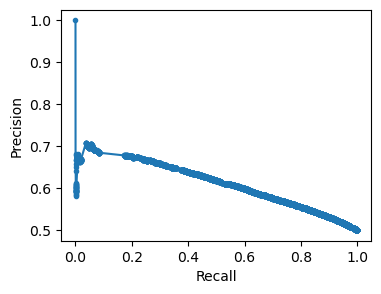

In [74]:
y_prob = ret_model_log.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(4,3))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Decreasing **precision** for more **recall** is a possible option, but as we get closer to 0.5 precision, the less useful our model becomes. The current results seem like a good balance, so we'll leave it as is.

Next we'll want to try to increase accuracy, so let's search for the best **hyperparameters** using a grid search with cross-validation.

In [75]:
param_grid = {
    'C': [1, 8, 10, 12],
    'solver':['lbfgs','liblinear','sag'],
}

grid_search = GridSearchCV(ret_model_log, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print("Classification Report\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.5967647756697925
Classification Report
               precision    recall  f1-score   support

       False       0.61      0.54      0.57     60577
        True       0.59      0.65      0.62     60590

    accuracy                           0.60    121167
   macro avg       0.60      0.60      0.59    121167
weighted avg       0.60      0.60      0.59    121167



There we have it. Even with hyperparameter tuning, we're not getting any noticeable increases in accuracy, which means that the base model may have already found the best hyperparameters on its own.

Good results nonetheless. Let's try now with **Random Forest**.

## Job satisfaction predicting retention: Random Forest

In [76]:
ret_model_rf = RandomForestClassifier(n_estimators=10, random_state=69)
ret_model_rf.fit(X_train, y_train)

y_pred = ret_model_rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Feature Importance:")
for i, feature in enumerate(X.columns):
    print("{}: {:.2f}".format(feature, ret_model_rf.feature_importances_[i]))

Classification Report:
               precision    recall  f1-score   support

       False       0.60      0.56      0.58     60577
        True       0.59      0.63      0.61     60590

    accuracy                           0.60    121167
   macro avg       0.60      0.60      0.60    121167
weighted avg       0.60      0.60      0.60    121167

Feature Importance:
rating: 0.15
recommend: 0.06
ceo_approv: 0.11
bus_outlook: 0.09
comp_benefits: 0.14
senior_mgmt: 0.15
wl_balance: 0.15
cult_values: 0.14


Very similar results to the Logistic Regression, but **slightly better**. The feature importances are pretty different from the coefficients in the regression though, which is interesting. This also supports the hypothesis that **job satisfaction has some positive correlation with employee retention**.

Let's do some **hyperparameter searching**.

In [77]:
param_grid = {
    'max_depth': [None, 10, 11, 12],        # Maximum depth of the tree
    'min_samples_split': [4, 5, 6],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],             # Minimum number of samples required to be at a leaf node
    'max_features': [2, 'log2', 3],         # Number of features to consider when looking for the best split
    'bootstrap': [True, False]              # Whether bootstrap samples are used when building trees
}

grid_search = GridSearchCV(ret_model_rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print("Classification Report\n", classification_report(y_test, y_pred))

Best Parameters: {'bootstrap': False, 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Cross-Validation Accuracy: 0.6048074443172088
Classification Report
               precision    recall  f1-score   support

       False       0.60      0.61      0.60     60577
        True       0.60      0.60      0.60     60590

    accuracy                           0.60    121167
   macro avg       0.60      0.60      0.60    121167
weighted avg       0.60      0.60      0.60    121167



**0.6** across the board, that's funny. Slightly better than before, but pretty much the same. Great.

Next, let's try with a **Support Vector Machine**. Note that SVM takes a very long time to train and is more prone to overfitting compared to Logistic Regression and Random Forest, so we'll search for hyperparameters with a much smaller random sample of the original dataset.

## Job satisfaction predicting retention: Support Vector Machine

In [78]:
small_df = undersampled_df.sample(frac=0.1, random_state=69)
X_small = small_df[independent_vars]
y_small = small_df['retention']

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=69)

In [82]:
ret_model_svc = SVC(max_iter=10000, random_state=69)
ret_model_svc.fit(X_train, y_train)

y_pred = ret_model_svc.predict(X_test)
print("C value: ", ret_model_svc.C)
print("Classification Report:\n", classification_report(y_test, y_pred))

# param_grid = {'C': [0.001, 0.01, 0.1]}
# grid_search = GridSearchCV(estimator=ret_model_svc, param_grid=param_grid, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print("Best C value:", grid_search.best_params_['C'])

/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C value:  1.0
Classification Report:
               precision    recall  f1-score   support

       False       0.62      0.25      0.36      6079
        True       0.53      0.84      0.65      6038

    accuracy                           0.55     12117
   macro avg       0.58      0.55      0.51     12117
weighted avg       0.58      0.55      0.50     12117



On the first run, we get an accuracy of **0.55**. Note that the max_iter parameter is very important, if we have no limit then training takes a very long time.

In [87]:
ret_model_svc = SVC(random_state=69)

# param_grid = {
#     'C': [0.1, 1, 10],               # Regularization parameter
#     'kernel': ['linear', 'poly','rbf'],      # Specifies the kernel type
#     'gamma': ['scale', 'auto'],       # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'degree': [2, 3, 4],              # Degree of the polynomial kernel function ('poly')
#     'class_weight': [None, 'balanced'] # Adjusts weights inversely proportional to class frequencies
# }

param_grid = {
    'kernel': ['poly'],      # Specifies the kernel type
#     'gamma': ['scale', 'auto', 0.01, 0.0001],       # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3, 4],              # Degree of the polynomial kernel function ('poly')
#     'class_weight': [None, 'balanced'], # Adjusts weights inversely proportional to class frequencies
#     'tol': [0.0001, 0.001, 0.01],
    'max_iter': [10000, 20000]
}

grid_search = GridSearchCV(ret_model_svc, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print("Classification Report\n", classification_report(y_test, y_pred))

/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: Conver

Best Parameters: {'degree': 3, 'kernel': 'poly', 'max_iter': 20000}
Best Cross-Validation Accuracy: 0.5741344447654025
Classification Report
               precision    recall  f1-score   support

       False       0.42      0.43      0.43      6079
        True       0.42      0.41      0.41      6038

    accuracy                           0.42     12117
   macro avg       0.42      0.42      0.42     12117
weighted avg       0.42      0.42      0.42     12117



In [100]:
ret_model_svc = SVC(random_state=69)

param_grid = {
    'kernel': ['rbf', 'linear','poly'],
    'degree': [2, 3],
    'max_iter': [10000, 20000]
}

grid_search = GridSearchCV(ret_model_svc, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

print("Classification Report\n", classification_report(y_test, y_pred))

/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: Conver

KeyboardInterrupt: 

In [84]:
# Attempting best without gridsearch

ret_model_svc = SVC(max_iter=20000, random_state=69)
ret_model_svc.fit(X_train, y_train)

y_pred = ret_model_svc.predict(X_test)
print("C value: ", ret_model_svc.C)
print("Classification Report:\n", classification_report(y_test, y_pred))

/Users/matth/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


C value:  1.0
Classification Report:
               precision    recall  f1-score   support

       False       0.60      0.58      0.59      6079
        True       0.59      0.61      0.60      6038

    accuracy                           0.60     12117
   macro avg       0.60      0.60      0.60     12117
weighted avg       0.60      0.60      0.60     12117



In [ ]:
ret_model_svc = SVC(kernel='linear', C=0.01, max_iter=500000, random_state=69)
ret_model_svc.fit(X_train, y_train)

y_pred = ret_model_svc.predict(X_test)
print("C value: ", ret_model_svc.C)
print("Classification Report:\n", classification_report(y_test, y_pred))

In consequence, the original Logistic Regression and Random Forest had the best results, with an accuracy of 0.6 using an equal split of True/False input rows. This indicates that there is a predictive relationship between job satisfaction and retention, but it is fairly weak.

Next, let's move on to the financial data.

## Do some data visualisation: try plotting one quarter of rating vs market cap. E.g. plot a full year.

## Can also calculate correlation directly.

## Think about averaging all the ratings and job satisfaction facets per quarter. The problem is that your market cap and return on assets are static for each quarter.

### To think about: classify different classes of market cap size


Try to split training and testing by companies. I.e. 80% of 232 companies in training, 20% in testing.
- Point of this is to make sure the model works for completely new companies.

Try train_test_split for one company (Amazon), using 80% of dates from the past and 20% as the most recent dates.

Alright, let's try the financial data then. First off: **mcapq**.

In [ ]:
X = final_df[independent_vars]
y = final_df['mcapq_prev_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

mcap_model = LinearRegression(n_jobs=-1)

mcap_model.fit(X_train, y_train)

y_pred = mcap_model.predict(X_test)

print("Coefficients: ", mcap_model.coef_)
print("Intercept: ", mcap_model.intercept_)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

0.0012 R^2 is really insignificant, which is actually pretty mindblowing in terms of discussion. So that's basically indicating that job satisfaction has almost no effect on the market cap of tech companies. 

Let's give it a try with Random Forest.

In [ ]:
mcap_model_rf = RandomForestRegressor(random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

The default hyperparameters give us very bad results, likely due to overfitting. Let's play around with them until we achieve a reasonable R^2 score.

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Best max_depth appears to be 11, while higher n_estimators gets better results.

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_split=10, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_split=5, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_split=20, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Default min_samples_split seems best. Onto min_samples_leaf

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_leaf=5, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, min_samples_leaf=20, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Default min_samples_leaf seems best. Onto max_features

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, max_features='sqrt', random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, max_features='log2', random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, max_features=2, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=10, max_depth=11, max_features=4, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

max_features = 4 seems best. Let's put it all together and use a high n_estimators.

In [ ]:
mcap_model_rf = RandomForestRegressor(n_estimators=1000, max_depth=11, max_features=4, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Awesome. That's Random Forest done, let's move onto SVR. We'll start with a really undersampled df to speed up predictions.

In [ ]:
small_df = undersampled_df.sample(frac=0.05, random_state=69)
X_small = small_df[independent_vars]
y_small = small_df['mcapq_prev_change']

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=69)

In [ ]:
mcap_model_svr = SVR(kernel='linear', max_iter=5000)
mcap_model_svr.fit(X_train, y_train)

y_pred = mcap_model_svr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

We're getting a really bad R^2 because the model is overfitting. We'll do a bunch of hyperparameter tuning and see what we can come up with.

The below model has undergone a lot of hyperparameter testing using GridSearchCV to find the best hyperparameters.

In [ ]:
mcap_model_svr = SVR(kernel='rbf', C=0.001, epsilon=0.2, max_iter=10000)
mcap_model_svr.fit(X_train, y_train)

y_pred = mcap_model_svr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

Great, let's try for the next quarter now. Linear Regression followed by Random Forest followed by SVR.

In [ ]:
y = final_df['mcapq_next_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

mcap_model = LinearRegression(n_jobs=-1)

mcap_model.fit(X_train, y_train)

y_pred = mcap_model.predict(X_test)

print("Coefficients: ", mcap_model.coef_)
print("Intercept: ", mcap_model.intercept_)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Similar insignificant result. Very interesting.see how it fares for the market cap of the next quarter.

Let's try with Random Forest.

In [ ]:
y = final_df['mcapq_prev_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

mcap_model_rf = RandomForestRegressor(n_estimators=100, random_state=69)
mcap_model_rf.fit(X_train, y_train)

y_pred = mcap_model_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)



Now let's give it a shot with ROA.

In [ ]:
y = final_df['roaq_prev_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

roa_model = LinearRegression(n_jobs=-1)

roa_model.fit(X_train, y_train)

y_pred = roa_model.predict(X_test)

print("Coefficients: ", roa_model.coef_)
print("Intercept: ", roa_model.intercept_)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Wow, pretty much no correlation once again. That's again surprising and worthy of a lot of discussion. Let's try with the next quarter:

In [ ]:
y = final_df['roaq_next_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

roa_model = LinearRegression(n_jobs=-1)

roa_model.fit(X_train, y_train)

y_pred = roa_model.predict(X_test)

print("Coefficients: ", roa_model.coef_)
print("Intercept: ", roa_model.intercept_)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R-squared: ", r2)
print("Mean Squared Error: ", mse)

Interesting. ROA has virtually no correlation whatsoever as well. And similarly to market cap, forecasting the next quarter only decreases the strength of the relationship.